## IMPORTING ALL REQUIRED LIBRARIES

In [31]:
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.pipeline import (Pipeline,
                              FeatureUnion)

from feature_engine.encoding import (RareLabelEncoder,
                                     MeanEncoder,
                                     CountFrequencyEncoder
                                    )

from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   PowerTransformer,
                                   FunctionTransformer
                                  )

from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

sklearn.set_config(transform_output='default')
pd.set_option("display.max_columns", None)

## 2. IMPORTING DATASETS

In [3]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
val = pd.read_csv("Validation.csv")

In [4]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,class,price
0,IndiGo,2019-05-09,Delhi,Cochin,06:50:00,16:10:00,560,1.0,No Info,Economy,6442
1,Air India,2019-04-03,Mumbai,Hyderabad,06:20:00,07:40:00,80,0.0,No Info,Economy,3100
2,SpiceJet,2019-05-15,Kolkata,Banglore,11:15:00,18:30:00,435,1.0,No Info,Economy,8844
3,Jet Airways,2019-06-09,Delhi,Cochin,19:45:00,12:35:00,1010,1.0,In-flight meal not included,Economy,10577
4,Jet Airways,2019-06-18,Delhi,Cochin,09:50:00,13:05:00,195,0.0,No Info,Economy,9564


In [5]:
test.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,class,price
0,SpiceJet,2019-03-09,Chennai,Kolkata,08:20:00,10:35:00,135,0.0,No Info,Economy,6300
1,Jet Airways,2019-05-27,Delhi,Cochin,13:25:00,04:25:00,900,2.0,No Info,Economy,16704
2,Multiple carriers,2019-05-09,Delhi,Cochin,11:30:00,01:30:00,840,1.0,No Info,Economy,15078
3,IndiGo,2019-06-18,Kolkata,Banglore,21:25:00,00:05:00,160,0.0,No Info,Economy,4804
4,Multiple carriers,2019-05-21,Delhi,Cochin,14:00:00,21:00:00,420,1.0,No Info,Economy,14067


In [6]:
val.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,class,price
0,SpiceJet,2019-06-01,Banglore,Delhi,05:55:00,08:35:00,160,0.0,No Info,Economy,3625
1,Jet Airways,2019-06-21,Banglore,Delhi,17:45:00,20:45:00,180,0.0,In-flight meal not included,Economy,7754
2,Jet Airways,2019-03-12,Banglore,New Delhi,05:45:00,20:20:00,875,1.0,No Info,Economy,13817
3,Jet Airways,2019-06-12,Mumbai,Hyderabad,19:35:00,21:05:00,90,0.0,No Info,Economy,5678
4,Jet Airways,2019-06-27,Delhi,Cochin,15:00:00,12:35:00,1295,1.0,In-flight meal not included,Economy,10262


## 3. PREPROCESSING OPERATIONS

In [7]:
# AIRLINE PREPROCESSING
Airline_Transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="most_frequent")),
    ("Grouper", RareLabelEncoder(tol=0.1,
                                 n_categories = 2,
                                 replace_with = "Other")),
     ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore',
                                    sparse_output=False))
])

# DATA OF JOURNEY PREPROCESSING
DOJ_Transformer = Pipeline(steps=[
    ("DateTime", DatetimeFeatures(features_to_extract=['month', 'week', 'day_of_week', 'day_of_month'],
                                 yearfirst=True,
                                format='mixed')),
    ("Scalar", MinMaxScaler())
])

# SOURCE AND DESTINATION PREPROCESSING
SourceDestination_Pipe = Pipeline(steps=[
    ("Grouper", RareLabelEncoder(tol=0.1,
                                n_categories=2,
                                replace_with="Other"
                               )),
    ("MeanEncoder", MeanEncoder()),
    ("Scalar", PowerTransformer())
])

def is_north(X):
    if isinstance(X, np.ndarray):  # Check if the input is a numpy array
        X = pd.DataFrame(X, columns=['source', 'destination'])  # Adjust column names based on your input

    north_cities = ['Delhi', 'New Delhi', 'Kolkata']
    
    return (
        X.assign(**{
            f"{col}_is_north": X[col].isin(north_cities).astype(int)
            for col in X.columns
        }).drop(columns=X.columns)
    )

SourceDestination_Transformer = FeatureUnion(transformer_list=[
    ("Part-1", SourceDestination_Pipe),
    ("Part-2", FunctionTransformer(func=is_north))
])


# ARRIVAL TIME DEPARTURE TIME PREPROCESSING
time_pipe_1 = Pipeline(steps=[
    ("DT", DatetimeFeatures(features_to_extract=['hour', 'minute'])),
    ("Scalar", MinMaxScaler())
])

def part_of_day(X, morning=4, noon=12, evening=16, night=20):
    if isinstance(X, np.ndarray):  # Check if input is a numpy array
        X = pd.DataFrame(X, columns=['dep_time', 'arrival_time'])  # Adjust column names based on your input

    X_Temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in X.columns
    })

    return (
        X_Temp.assign(**{
            f"{col}_part_of_day": np.select(
                [X_Temp.loc[:, col].between(morning, noon, inclusive='left'),
                 X_Temp.loc[:, col].between(noon, evening, inclusive='left'),
                 X_Temp.loc[:, col].between(evening, night, inclusive='left')],
                ['morning', 'afternoon', 'evening'],
                default='night'
            )
            for col in X_Temp.columns
        }).drop(columns=X.columns)
    )

time_pipe_2 = Pipeline(steps=[
    ("Part_of_Day", FunctionTransformer(func=part_of_day)),
    ("Encoder", CountFrequencyEncoder()),
    ("Scalar", MinMaxScaler())
    
])

ArrivalDepartureTime_Transformer = FeatureUnion(transformer_list=[
    ("Part_1", time_pipe_1),
    ("Part_2", time_pipe_2)
])


# DURATION PREPROCESSING

Duration_Transformer = Pipeline(steps=[
    ("Outlier", Winsorizer(capping_method='iqr', fold=1.5)),
    ('Imputer', SimpleImputer(strategy='median')),
    ("scalar", PowerTransformer())
])


# TOTAL STOP PREPROCESSING

def is_direct(X):
    # Check if X is a NumPy array, and if so, convert it to a DataFrame
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=['total_stops'])  # Specify correct column name(s) here
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

TotalStop_Transformer = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy='most_frequent')),
    ("isDirectFlight", FunctionTransformer(func=is_direct))
])


# ADDITIONAL INFO PREPROCESSING
AdditionalInfo_Transformation = Pipeline(steps=[
    ("Grouper", RareLabelEncoder(tol=0.2, n_categories=2, replace_with='Info')),
    ("Encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


# CLASS PREPROCESSING 
Class_Transformer = Pipeline(steps=[
    ("Encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore' ))
])


# COLUMNS TRANSFORMER

Column_Transformer = ColumnTransformer(transformers=[
    ("Airline", Airline_Transformer, ['airline']),
    ("DOJ", DOJ_Transformer, ['date_of_journey']),
    ("Location", SourceDestination_Transformer, ["source", 'destination']),
    ("Time", ArrivalDepartureTime_Transformer, ["dep_time", "arrival_time"]),
    ("Duration", Duration_Transformer, ['duration']),
    ("Stops", TotalStop_Transformer, ['total_stops']),
    ("Info", AdditionalInfo_Transformation, ['additional_info']),
    ("Class", Class_Transformer, ['class'])
], remainder='passthrough')


preprocessor = Pipeline(steps=[
    ("ct", Column_Transformer),  
])

preprocessor.fit(
    train.drop(columns='price'),
    train.price.copy()
)


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Airline',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('DOJ',
                                                  Pipeline(steps=[('Da...
                                                                   FunctionTransformer(func=<function is_direct at 0x0000029A97F89BD0>))]),
                                                  ['total_stops']),
                                                 ('Info',
                                                  Pipeline(steps=[('Grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Info',
                                                                                    tol=0.2)),
                                                                  ('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['additional_info']),
                                                 ('Class',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['class'])]))])

In [8]:
X_Train = train.drop(['price'], axis = 1)
Y_Train = train['price']

In [9]:
preprocessor.transform(train.drop(columns="price"))

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [10]:
transformed_data = Column_Transformer.fit_transform(X_Train, Y_Train)
transformed_df = pd.DataFrame(transformed_data)
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.0,1.0,0.0,0.0,0.0,0.666667,0.588235,0.500000,0.307692,1.040285,1.039038,1.0,0.0,0.260870,0.909091,0.695652,0.181818,1.000000,0.654008,0.242156,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.333333,0.294118,0.333333,0.076923,-1.878057,-0.848449,0.0,0.0,0.260870,0.363636,0.304348,0.727273,1.000000,0.855485,-1.777309,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.333333,0.538462,-0.205899,-0.211326,1.0,0.0,0.478261,0.272727,0.782609,0.545455,1.000000,0.654008,-0.043462,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,1.000000,0.307692,1.040285,1.039038,1.0,0.0,0.826087,0.818182,0.521739,0.636364,0.211834,0.000000,0.938128,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.000000,0.941176,0.166667,0.653846,1.040285,1.039038,1.0,0.0,0.391304,0.909091,0.565217,0.090909,1.000000,0.000000,-0.903335,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## 4. MODEL SELECTION

#### IMPORTING ALL LIBRARIES WHICH WE WILL USE FOR MODEL SELECTION

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

#### MAKING DICTIONARY OF ALL ML ALGORITHM THAT WE WILL TRY

In [32]:
algorithm = {
    "LINEAR REGRESSION": LinearRegression(),
    "SUPPORT VECTOR MACHINE": SVR(),
    "RANDOM FOREST": RandomForestRegressor(n_estimators=10),
    "XG BOOST": XGBRegressor(n_estimators = 10),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "GRADIENT BOOSTING REGRESSOR": GradientBoostingRegressor(),
    "DECISION TREE REGRESSOR": DecisionTreeRegressor()
    
}

#### SPLITING DATA

In [13]:

def split_data(data):
    x = data.drop(columns='price')
    y = data['price']
    return x, y

data = pd.concat([train, val], axis=0)
X_data, y_data = split_data(train)
x_val, y_val = split_data(val)
x_test, y_test = split_data(test)

#### PLOTTING PLOTS TO CHECK AND COMPARE SCORE

In [14]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
                sizes, 
                mean_scores,
                marker = "o",
                label = label
    )
    
    ax.fill_between(
                x = sizes,
                y1 = mean_scores - std_scores,
                y2 = mean_scores + std_scores,
                alpha = 0.5
    )

In [34]:
def plot_learning_curves(name, algorithm, figsize = (6, 3)):
    model = Pipeline(steps=[
                    ("pre", preprocessor),
                    ("alg", algorithm)
    ])
    
    train_size, train_scores, test_scores = learning_curve(
                    estimator=model,
                    X = X_data, 
                    y = y_data,
                    cv = 3, 
                    scoring = "r2",
                    n_jobs = -1, 
                    random_state = 42
    )
    
    mean_train_scores = np.mean(train_scores, axis = 1)
    std_train_scores = np.std(train_scores, axis = 1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores, axis = 1)
    std_test_scores = np.std(test_scores, axis = 1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {mean_test_scores[-1]:.2f}"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # for train curve
    plot_curves(
                    train_size,
                    mean_train_scores,
                    std_train_scores,
                    f"Train ({train_score})",
                    ax
    )
    
    # for test curve
    plot_curves(
                    train_size,
                    mean_test_scores,
                    std_test_scores,
                    f"Test ({test_score})",
                    ax
    )
    
    ax.set(xlabel = "Training set size", ylabel = "R-square", title = name)
    ax.legend(loc = "lower right")
    plt.show()

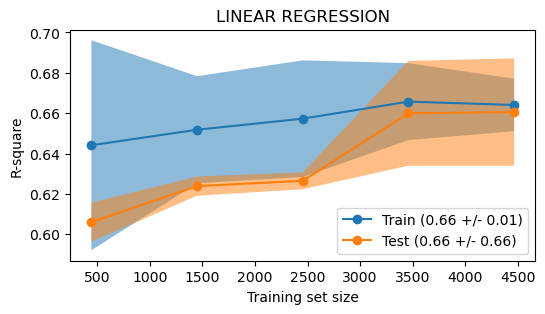

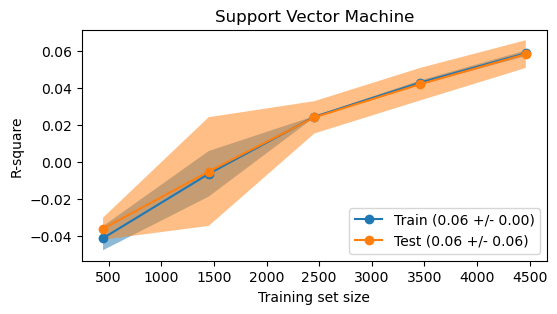

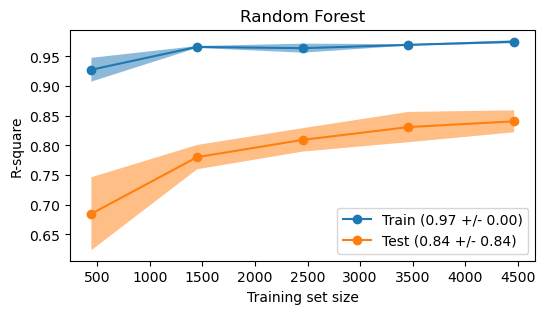

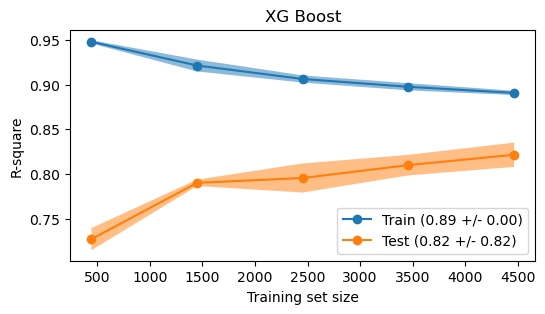

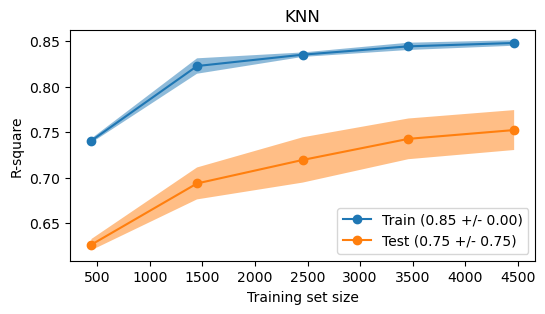

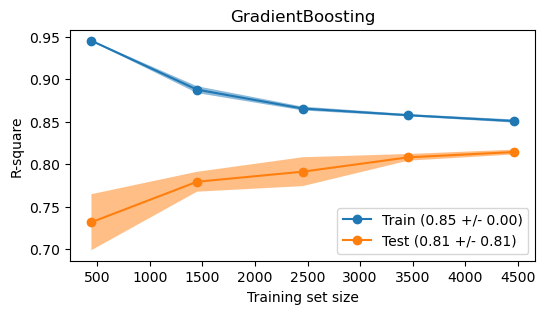

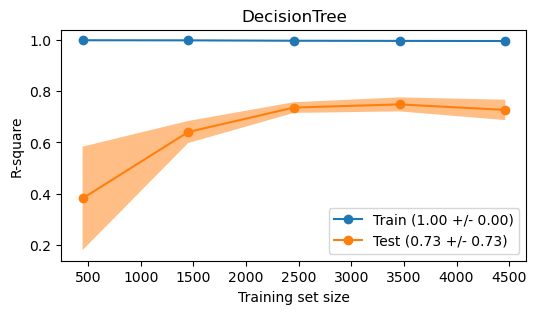

In [35]:
for name, alg in algorithm.items():
    plot_learning_curves(name, alg)

In [17]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

#### COMPARING BEST ALGORITHM

In [18]:

model = Pipeline(steps=[
    ("pre", preprocessor),
    ("XG Boost", XGBRegressor(n_estimators = 10))
])

model.fit(X_data, y_data)

print("TRAINING SCORE :- ",evaluate_model(X_data, y_data))
print("TESTING SCORE :- ",evaluate_model(x_test, y_test))
print("VALIDATION SCORE :-",evaluate_model(x_val, y_val))

TRAINING SCORE :-  0.882553219795227
TESTING SCORE :-  0.8158304691314697
VALIDATION SCORE :- 0.8140442967414856


In [19]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("XG Boost", GradientBoostingRegressor())
])

model.fit(X_data, y_data)

print("TRAINING SCORE :- ",evaluate_model(X_data, y_data))
print("TESTING SCORE :- ",evaluate_model(x_test, y_test))
print("VALIDATION SCORE :-",evaluate_model(x_val, y_val))


TRAINING SCORE :-  0.8454666778496742
TESTING SCORE :-  0.7870530071903309
VALIDATION SCORE :- 0.7953021643493138


In [20]:
algorithm = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators = 10),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "GradientBoosting": GradientBoostingRegressor(),
    "DecisionTree": DecisionTreeRegressor()
    
}

In [21]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("XG Boost", KNeighborsRegressor(n_neighbors=5))
])

model.fit(X_data, y_data)

print("TRAINING SCORE :- ",evaluate_model(X_data, y_data))
print("TESTING SCORE :- ",evaluate_model(x_test, y_test))
print("VALIDATION SCORE :-",evaluate_model(x_val, y_val))


TRAINING SCORE :-  0.8521006686061313
TESTING SCORE :-  0.7556563416408748
VALIDATION SCORE :- 0.736977779462199


In [22]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("XG Boost", DecisionTreeRegressor())
])

model.fit(X_data, y_data)

print("TRAINING SCORE :- ",evaluate_model(X_data, y_data))
print("TESTING SCORE :- ",evaluate_model(x_test, y_test))
print("VALIDATION SCORE :-",evaluate_model(x_val, y_val))


TRAINING SCORE :-  0.9952450351563825
TESTING SCORE :-  0.8160679772850427
VALIDATION SCORE :- 0.7755844407750931


Therefore, 
After comparing all of the best algorithms, we conclude that XG Boost is performing well in terms of all testing, validation, and training datasets, so we will use XG Boost.

####  HYPERPARAMETER TUNING USING RANDOM SEARCH

In [23]:

import xgboost as xgb

xgboost_model = xgb.XGBRegressor()

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    xgboost_model,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=3,
    n_jobs=-1,
    random_state=42
)

random_search.fit(transformed_df, y_data)

print("Best Hyperparameters: ", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters:  {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [36]:
best_param = {'subsample': 0.8,
              'reg_lambda': 2,
              'reg_alpha': 1,
              'n_estimators': 300,
              'max_depth': 6,
              'learning_rate': 0.1,
              'gamma': 0,
              'colsample_bytree': 0.6
}

In [25]:
y_data.shape

(6695,)

#### At last, training our model using all the best hyperparameters that we get using random search

In [37]:

model = Pipeline(steps=[
    ("pre", preprocessor),
    ("XG Boost", XGBRegressor(**best_param))
])

model.fit(X_data, y_data)

print("TRAINING SCORE :- ",evaluate_model(X_data, y_data))
print("TESTING SCORE :- ",evaluate_model(x_test, y_test))
print("VALIDATION SCORE :-",evaluate_model(x_val, y_val))

TRAINING SCORE :-  0.9747482538223267
TESTING SCORE :-  0.8783992528915405
VALIDATION SCORE :- 0.8683775663375854


#### MODEL PRESISTANCE

In [28]:
import joblib
joblib.dump(model, "model.joblib")

['model.joblib']

In [29]:
saved_model = joblib.load('model.joblib')

In [30]:
saved_model

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Airline',
                                                                   Pipeline(steps=[('Imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('Grouper',
                                                                                    RareLabelEncoder(n_categories=2,
                                                                                                     replace_with='Other',
                                                                                                     tol=0.1)),
                                                                                   ('OneHotEncoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['airline']),
                                                                  ('DO...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])